## Level 1: Unit sales of all products, aggregated for all stores/states

In [1]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from tsforest.trend import compute_trend_models
from tsforest.forecaster import LightGBMForecaster

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage
from evaluation import WRMSSEEvaluator


SEEDS = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71]

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



***

In [2]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .groupby(["ds"])
        .agg({"q":"sum",
              "event_name_1":lambda x: int(x.unique()),
             })
        .reset_index()
       )
data["q"] = data.q.astype(int)
data.rename({"q":"y"}, axis=1, inplace=True)

In [3]:
data.sort_values(["ds"], inplace=True)
data.reset_index(drop=True, inplace=True)

In [4]:
scale_factor = np.sqrt(np.nanmean(data.y.diff(1)**2))
scale_factor

INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


5926.012712033271

***

In [5]:
def make_valid_periods(end_date, valid_length, n_folds):
    right_date = pd.to_datetime(end_date)
    valid_periods = list()
    
    for i in range(n_folds):
        left_date = right_date - pd.DateOffset(days=valid_length-1)
        valid_periods.append((left_date, right_date))
        right_date = left_date - pd.DateOffset(days=1)
    
    return valid_periods[::-1]

In [6]:
#valid_periods = [(pd.to_datetime("2015-04-25"), pd.to_datetime("2015-05-22")),
#                 (pd.to_datetime("2015-05-23"), pd.to_datetime("2015-06-19")),
#                 (pd.to_datetime("2016-01-29"), pd.to_datetime("2016-02-26")),
#                 (pd.to_datetime("2016-02-27"), pd.to_datetime("2016-03-26")),
#                 (pd.to_datetime("2016-03-27"), pd.to_datetime("2016-04-24")),
#                ]
#valid_periods = [(pd.to_datetime("2016-03-27"), pd.to_datetime("2016-04-24")), ]

valid_periods = make_valid_periods("2016-04-24", valid_length=28, n_folds=13)
valid_periods

[(Timestamp('2015-04-27 00:00:00'), Timestamp('2015-05-24 00:00:00')),
 (Timestamp('2015-05-25 00:00:00'), Timestamp('2015-06-21 00:00:00')),
 (Timestamp('2015-06-22 00:00:00'), Timestamp('2015-07-19 00:00:00')),
 (Timestamp('2015-07-20 00:00:00'), Timestamp('2015-08-16 00:00:00')),
 (Timestamp('2015-08-17 00:00:00'), Timestamp('2015-09-13 00:00:00')),
 (Timestamp('2015-09-14 00:00:00'), Timestamp('2015-10-11 00:00:00')),
 (Timestamp('2015-10-12 00:00:00'), Timestamp('2015-11-08 00:00:00')),
 (Timestamp('2015-11-09 00:00:00'), Timestamp('2015-12-06 00:00:00')),
 (Timestamp('2015-12-07 00:00:00'), Timestamp('2016-01-03 00:00:00')),
 (Timestamp('2016-01-04 00:00:00'), Timestamp('2016-01-31 00:00:00')),
 (Timestamp('2016-02-01 00:00:00'), Timestamp('2016-02-28 00:00:00')),
 (Timestamp('2016-02-29 00:00:00'), Timestamp('2016-03-27 00:00:00')),
 (Timestamp('2016-03-28 00:00:00'), Timestamp('2016-04-24 00:00:00'))]

***
### training validation models

In [7]:
model_params = {
    'objective':'l2',
    'metric':'rmse',
    'num_iterations':10000,
    'early_stopping_rounds':250,
    #'max_bin': 255,
    'num_leaves': 23, 
    'learning_rate': 0.1, 
    'min_data_in_leaf': 20,
    #'min_sum_hessian_in_leaf':1e-4,
    'feature_fraction': 0.66,
    'bagging_fraction':0.9,
    'bagging_freq':1,
    'lambda_l2':1.,
    'seed':23
}

time_features = [
    "year",
    "month",
    "year_week",
    "year_day",
    "week_day",
    "month_progress",
    "week_day_cos",
    "week_day_sin",
    "year_day_cos",
    "year_day_sin",
    "year_week_cos",
    "year_week_sin",
    "month_cos",
    "month_sin"
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "categorical_features":{"event_name_1":"default"},
}

In [8]:
# 4+ years of history
train_history = 1800

############################################### 1/13 ###############################################
##### Validation period: (Timestamp('2015-04-27 00:00:00'), Timestamp('2015-05-24 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 952.39it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 2452.63
[50]	valid_0's rmse: 2179.41
[75]	valid_0's rmse: 1964.17
[100]	valid_0's rmse: 1899.21
[125]	valid_0's rmse: 1868.27
[150]	valid_0's rmse: 1801.45
[175]	valid_0's rmse: 1741.97
[200]	valid_0's rmse: 1702.92
[225]	valid_0's rmse: 1754.14
[250]	valid_0's rmse: 1730.65
[275]	valid_0's rmse: 1755.67
[300]	valid_0's rmse: 1757.98
[325]	valid_0's rmse: 1758.29
[350]	valid_0's rmse: 1782.62
[375]	valid_0's rmse: 1758.41
[400]	valid_0's rmse: 1749.88
[425]	valid_0's rmse: 1738.92
Early stopping, best iteration is:
[198]	valid_0's rmse: 1699.78
RMSE: 1699.7831532108662
RMSSE: 0.2868342063727458


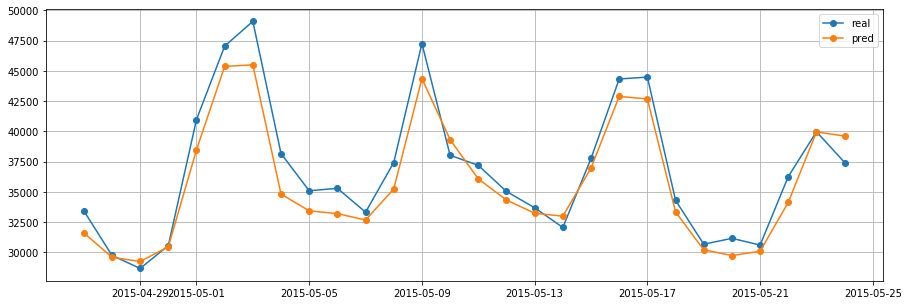

############################################### 2/13 ###############################################
##### Validation period: (Timestamp('2015-05-25 00:00:00'), Timestamp('2015-06-21 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1333.64it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 2973.09
[50]	valid_0's rmse: 2643.83
[75]	valid_0's rmse: 2512.16
[100]	valid_0's rmse: 2342.22
[125]	valid_0's rmse: 2297.75
[150]	valid_0's rmse: 2246.27
[175]	valid_0's rmse: 2246.28
[200]	valid_0's rmse: 2240.05
[225]	valid_0's rmse: 2225.77
[250]	valid_0's rmse: 2222.58
[275]	valid_0's rmse: 2217.48
[300]	valid_0's rmse: 2216.11
[325]	valid_0's rmse: 2253.2
[350]	valid_0's rmse: 2260.34
[375]	valid_0's rmse: 2249.09
[400]	valid_0's rmse: 2254.24
[425]	valid_0's rmse: 2247.23
[450]	valid_0's rmse: 2241.67
[475]	valid_0's rmse: 2237.22
[500]	valid_0's rmse: 2226.55
Early stopping, best iteration is:
[255]	valid_0's rmse: 2209.51
RMSE: 2209.5074050763506
RMSSE: 0.37284891417626537


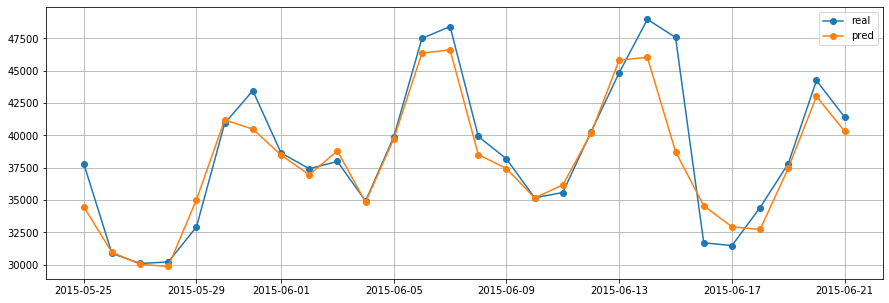

############################################### 3/13 ###############################################
##### Validation period: (Timestamp('2015-06-22 00:00:00'), Timestamp('2015-07-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1637.76it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 3587.44
[50]	valid_0's rmse: 3175.93
[75]	valid_0's rmse: 2984.52
[100]	valid_0's rmse: 2879.98
[125]	valid_0's rmse: 2761.24
[150]	valid_0's rmse: 2701.24
[175]	valid_0's rmse: 2656.27
[200]	valid_0's rmse: 2614.29
[225]	valid_0's rmse: 2603.73
[250]	valid_0's rmse: 2544.29
[275]	valid_0's rmse: 2499.28
[300]	valid_0's rmse: 2451.14
[325]	valid_0's rmse: 2441.29
[350]	valid_0's rmse: 2415.91
[375]	valid_0's rmse: 2406.11
[400]	valid_0's rmse: 2386.96
[425]	valid_0's rmse: 2380.88
[450]	valid_0's rmse: 2359.51
[475]	valid_0's rmse: 2339.36
[500]	valid_0's rmse: 2325.43
[525]	valid_0's rmse: 2325.06
[550]	valid_0's rmse: 2315.87
[575]	valid_0's rmse: 2306.7
[600]	valid_0's rmse: 2295.36
[625]	valid_0's rmse: 2283.19
[650]	valid_0's rmse: 2275.78
[675]	valid_0's rmse: 2266.06
[700]	valid_0's rmse: 2252.16
[725]	valid_0's rmse: 2237.75
[750]	valid_0's rmse: 2234.4
[775]	valid_0's rmse: 2226.71
[800]	valid_0

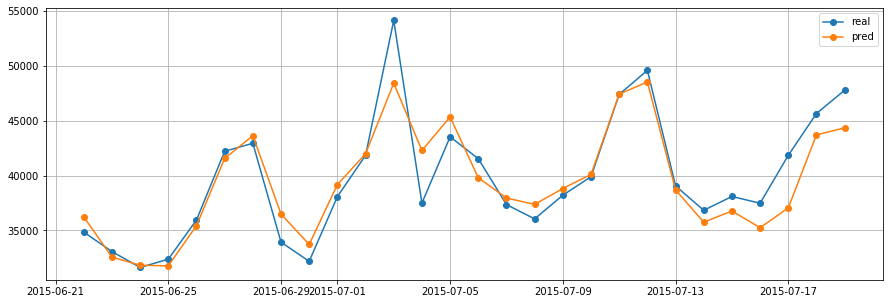

############################################### 4/13 ###############################################
##### Validation period: (Timestamp('2015-07-20 00:00:00'), Timestamp('2015-08-16 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1534.13it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 2300.85
[50]	valid_0's rmse: 1932.55
[75]	valid_0's rmse: 1787.19
[100]	valid_0's rmse: 1538
[125]	valid_0's rmse: 1415.6
[150]	valid_0's rmse: 1339.32
[175]	valid_0's rmse: 1365.23
[200]	valid_0's rmse: 1317.97
[225]	valid_0's rmse: 1297.21
[250]	valid_0's rmse: 1288.86
[275]	valid_0's rmse: 1289.25
[300]	valid_0's rmse: 1284.45
[325]	valid_0's rmse: 1269.96
[350]	valid_0's rmse: 1264.84
[375]	valid_0's rmse: 1231.73
[400]	valid_0's rmse: 1243.07
[425]	valid_0's rmse: 1248.69
[450]	valid_0's rmse: 1240.91
[475]	valid_0's rmse: 1252.74
[500]	valid_0's rmse: 1256.88
[525]	valid_0's rmse: 1240.09
[550]	valid_0's rmse: 1219.68
[575]	valid_0's rmse: 1195.46
[600]	valid_0's rmse: 1196.62
[625]	valid_0's rmse: 1181.88
[650]	valid_0's rmse: 1170.2
[675]	valid_0's rmse: 1163.56
[700]	valid_0's rmse: 1169.95
[725]	valid_0's rmse: 1150.49
[750]	valid_0's rmse: 1153.19
[775]	valid_0's rmse: 1147.43
[800]	valid_0's 

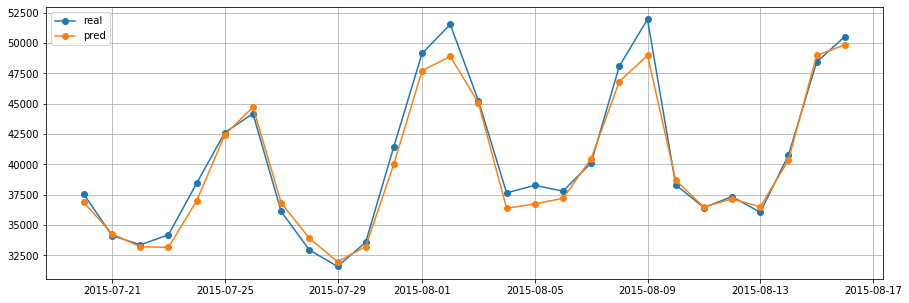

############################################### 5/13 ###############################################
##### Validation period: (Timestamp('2015-08-17 00:00:00'), Timestamp('2015-09-13 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 932.90it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 2013.12
[50]	valid_0's rmse: 1750.09
[75]	valid_0's rmse: 1704.71
[100]	valid_0's rmse: 1721.25
[125]	valid_0's rmse: 1715.52
[150]	valid_0's rmse: 1737.92
[175]	valid_0's rmse: 1752.78
[200]	valid_0's rmse: 1747.61
[225]	valid_0's rmse: 1747.79
[250]	valid_0's rmse: 1767.5
[275]	valid_0's rmse: 1774.19
[300]	valid_0's rmse: 1803.93
[325]	valid_0's rmse: 1815.95
Early stopping, best iteration is:
[85]	valid_0's rmse: 1693.26
RMSE: 1693.2606238837475
RMSSE: 0.2857335456681418


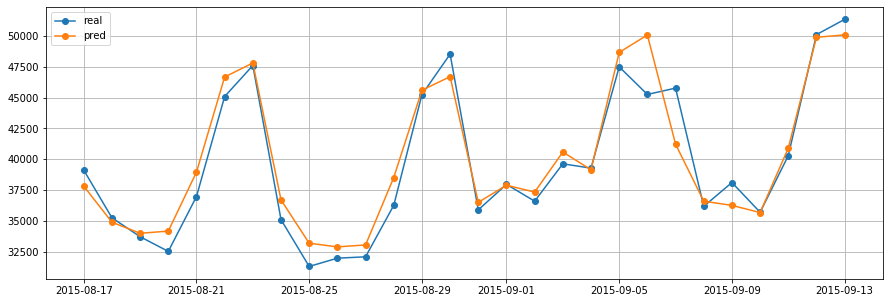

############################################### 6/13 ###############################################
##### Validation period: (Timestamp('2015-09-14 00:00:00'), Timestamp('2015-10-11 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1588.15it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 2353.76
[50]	valid_0's rmse: 1895.03
[75]	valid_0's rmse: 1836.65
[100]	valid_0's rmse: 1787.25
[125]	valid_0's rmse: 1802.2
[150]	valid_0's rmse: 1802.07
[175]	valid_0's rmse: 1845.24
[200]	valid_0's rmse: 1875.13
[225]	valid_0's rmse: 1836.84
[250]	valid_0's rmse: 1842.98
[275]	valid_0's rmse: 1847.14
[300]	valid_0's rmse: 1863.6
[325]	valid_0's rmse: 1858.77
[350]	valid_0's rmse: 1890.5
Early stopping, best iteration is:
[114]	valid_0's rmse: 1772.36
RMSE: 1772.3600052392792
RMSSE: 0.29908137079091174


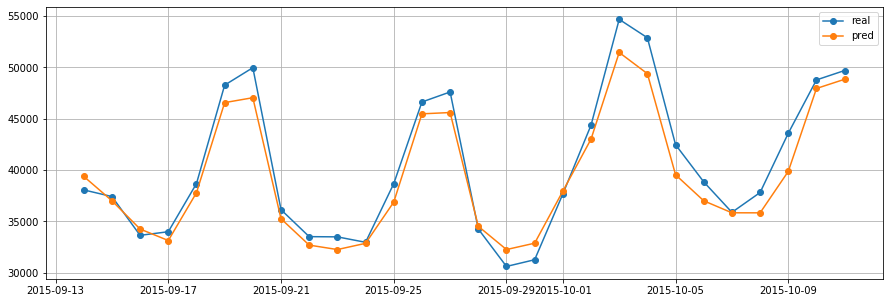

############################################### 7/13 ###############################################
##### Validation period: (Timestamp('2015-10-12 00:00:00'), Timestamp('2015-11-08 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 954.55it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 1646.25
[50]	valid_0's rmse: 1548.62
[75]	valid_0's rmse: 1461.07
[100]	valid_0's rmse: 1395.35
[125]	valid_0's rmse: 1380.71
[150]	valid_0's rmse: 1301.66
[175]	valid_0's rmse: 1270.48
[200]	valid_0's rmse: 1272.11
[225]	valid_0's rmse: 1279.28
[250]	valid_0's rmse: 1281.49
[275]	valid_0's rmse: 1279.95
[300]	valid_0's rmse: 1279.15
[325]	valid_0's rmse: 1259.79
[350]	valid_0's rmse: 1254.25
[375]	valid_0's rmse: 1282.47
[400]	valid_0's rmse: 1308.11
[425]	valid_0's rmse: 1308.68
[450]	valid_0's rmse: 1314.82
[475]	valid_0's rmse: 1309.69
[500]	valid_0's rmse: 1302.74
[525]	valid_0's rmse: 1305.04
[550]	valid_0's rmse: 1307.75
[575]	valid_0's rmse: 1302.67
Early stopping, best iteration is:
[341]	valid_0's rmse: 1252.52
RMSE: 1252.521474101433
RMSSE: 0.2113599033559415


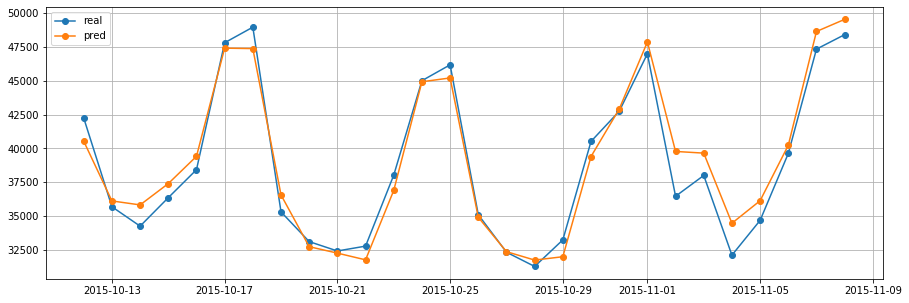

############################################### 8/13 ###############################################
##### Validation period: (Timestamp('2015-11-09 00:00:00'), Timestamp('2015-12-06 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1214.33it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 3291.01
[50]	valid_0's rmse: 2650.49
[75]	valid_0's rmse: 2458.66
[100]	valid_0's rmse: 2394.61
[125]	valid_0's rmse: 2286.26
[150]	valid_0's rmse: 2268.93
[175]	valid_0's rmse: 2243.72
[200]	valid_0's rmse: 2277.97
[225]	valid_0's rmse: 2254.6
[250]	valid_0's rmse: 2245.93
[275]	valid_0's rmse: 2213.05
[300]	valid_0's rmse: 2153.23
[325]	valid_0's rmse: 2142.41
[350]	valid_0's rmse: 2150.18
[375]	valid_0's rmse: 2101.63
[400]	valid_0's rmse: 2076.19
[425]	valid_0's rmse: 2060.76
[450]	valid_0's rmse: 2078.31
[475]	valid_0's rmse: 2087.85
[500]	valid_0's rmse: 2074.26
[525]	valid_0's rmse: 2047.28
[550]	valid_0's rmse: 2056.04
[575]	valid_0's rmse: 2056.91
[600]	valid_0's rmse: 2045.68
[625]	valid_0's rmse: 2043.58
[650]	valid_0's rmse: 2037.42
[675]	valid_0's rmse: 2032.07
[700]	valid_0's rmse: 2024.43
[725]	valid_0's rmse: 2039.13
[750]	valid_0's rmse: 2018.49
[775]	valid_0's rmse: 2024.03
[800]	valid_

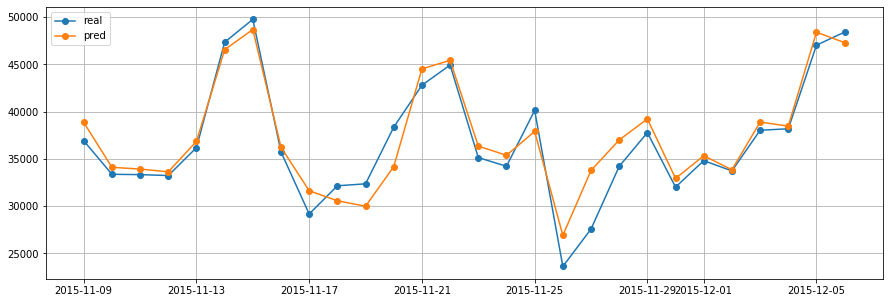

############################################### 9/13 ###############################################
##### Validation period: (Timestamp('2015-12-07 00:00:00'), Timestamp('2016-01-03 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1413.65it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 7506.93
[50]	valid_0's rmse: 6284.25
[75]	valid_0's rmse: 5547.96
[100]	valid_0's rmse: 5132
[125]	valid_0's rmse: 4818.73
[150]	valid_0's rmse: 4558.19
[175]	valid_0's rmse: 4324.12
[200]	valid_0's rmse: 4141.48
[225]	valid_0's rmse: 4020.57
[250]	valid_0's rmse: 3910.94
[275]	valid_0's rmse: 3840.83
[300]	valid_0's rmse: 3777.3
[325]	valid_0's rmse: 3724.26
[350]	valid_0's rmse: 3643.99
[375]	valid_0's rmse: 3626.51
[400]	valid_0's rmse: 3574.25
[425]	valid_0's rmse: 3576.63
[450]	valid_0's rmse: 3559.22
[475]	valid_0's rmse: 3530.35
[500]	valid_0's rmse: 3504.77
[525]	valid_0's rmse: 3501.84
[550]	valid_0's rmse: 3496.16
[575]	valid_0's rmse: 3502
[600]	valid_0's rmse: 3503.7
[625]	valid_0's rmse: 3511.01
[650]	valid_0's rmse: 3521.46
[675]	valid_0's rmse: 3522.88
[700]	valid_0's rmse: 3520.16
[725]	valid_0's rmse: 3516.06
[750]	valid_0's rmse: 3520.77
[775]	valid_0's rmse: 3531.49
Early stopping, bes

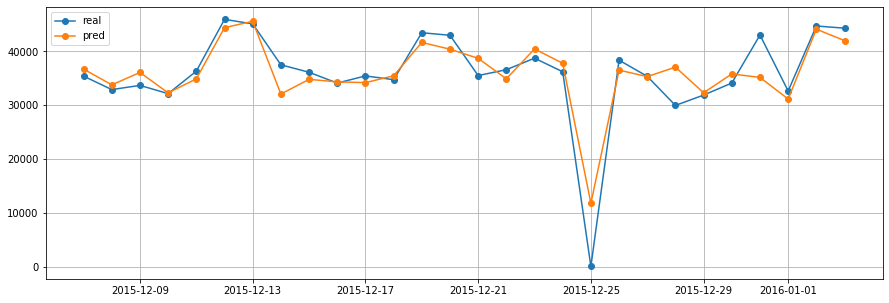

############################################## 10/13 ###############################################
##### Validation period: (Timestamp('2016-01-04 00:00:00'), Timestamp('2016-01-31 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1275.25it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 2493.16
[50]	valid_0's rmse: 2386.04
[75]	valid_0's rmse: 2333.86
[100]	valid_0's rmse: 2256.19
[125]	valid_0's rmse: 2200.75
[150]	valid_0's rmse: 2199.25
[175]	valid_0's rmse: 2143.61
[200]	valid_0's rmse: 2188.1
[225]	valid_0's rmse: 2199.36
[250]	valid_0's rmse: 2208.37
[275]	valid_0's rmse: 2214.71
[300]	valid_0's rmse: 2157.03
[325]	valid_0's rmse: 2173.6
[350]	valid_0's rmse: 2189.44
[375]	valid_0's rmse: 2198.28
[400]	valid_0's rmse: 2199.48
[425]	valid_0's rmse: 2188.5
Early stopping, best iteration is:
[177]	valid_0's rmse: 2129.36
RMSE: 2129.357443857535
RMSSE: 0.35932380629789984


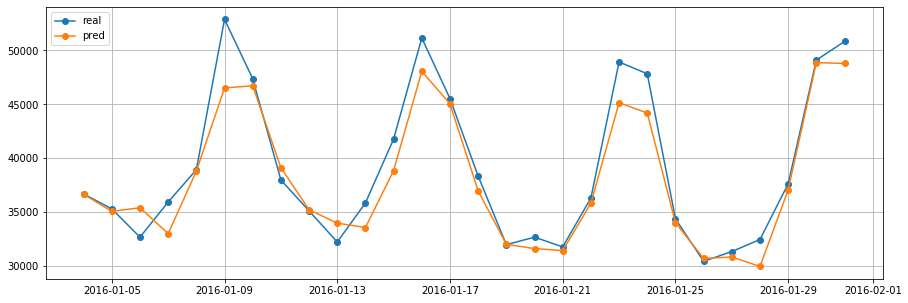

############################################## 11/13 ###############################################
##### Validation period: (Timestamp('2016-02-01 00:00:00'), Timestamp('2016-02-28 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1573.85it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 3373.05
[50]	valid_0's rmse: 3102.84
[75]	valid_0's rmse: 2883.23
[100]	valid_0's rmse: 2847.18
[125]	valid_0's rmse: 2804.76
[150]	valid_0's rmse: 2814.88
[175]	valid_0's rmse: 2829.53
[200]	valid_0's rmse: 2845.41
[225]	valid_0's rmse: 2832.57
[250]	valid_0's rmse: 2828.44
[275]	valid_0's rmse: 2840.12
[300]	valid_0's rmse: 2863.88
[325]	valid_0's rmse: 2887.44
[350]	valid_0's rmse: 2896.33
[375]	valid_0's rmse: 2906.3
Early stopping, best iteration is:
[142]	valid_0's rmse: 2785.83
RMSE: 2785.8265448864836
RMSSE: 0.4701013447422458


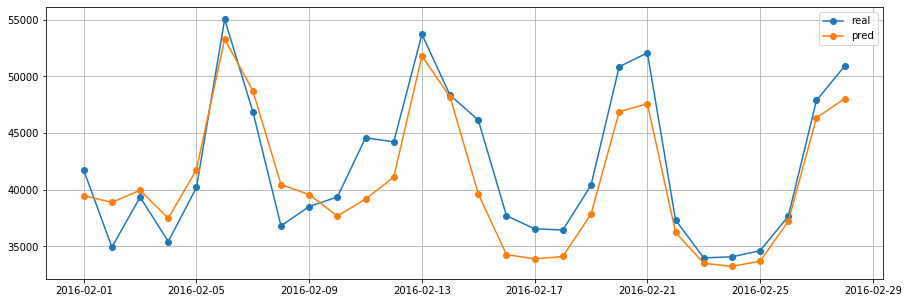

############################################## 12/13 ###############################################
##### Validation period: (Timestamp('2016-02-29 00:00:00'), Timestamp('2016-03-27 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1091.41it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 2734.19
[50]	valid_0's rmse: 2358.99
[75]	valid_0's rmse: 2224.17
[100]	valid_0's rmse: 2144.95
[125]	valid_0's rmse: 2150.15
[150]	valid_0's rmse: 2136.77
[175]	valid_0's rmse: 2120.2
[200]	valid_0's rmse: 2131.45
[225]	valid_0's rmse: 2139.91
[250]	valid_0's rmse: 2165.8
[275]	valid_0's rmse: 2161.15
[300]	valid_0's rmse: 2138.86
[325]	valid_0's rmse: 2124.13
[350]	valid_0's rmse: 2121.05
[375]	valid_0's rmse: 2130.49
[400]	valid_0's rmse: 2139.69
[425]	valid_0's rmse: 2150.58
[450]	valid_0's rmse: 2138.62
[475]	valid_0's rmse: 2144.58
[500]	valid_0's rmse: 2117.91
[525]	valid_0's rmse: 2109.75
[550]	valid_0's rmse: 2108.13
[575]	valid_0's rmse: 2104.75
[600]	valid_0's rmse: 2113.37
[625]	valid_0's rmse: 2120.11
[650]	valid_0's rmse: 2132.41
[675]	valid_0's rmse: 2125.15
[700]	valid_0's rmse: 2136.96
[725]	valid_0's rmse: 2136.72
[750]	valid_0's rmse: 2135.97
[775]	valid_0's rmse: 2135.04
[800]	valid_0

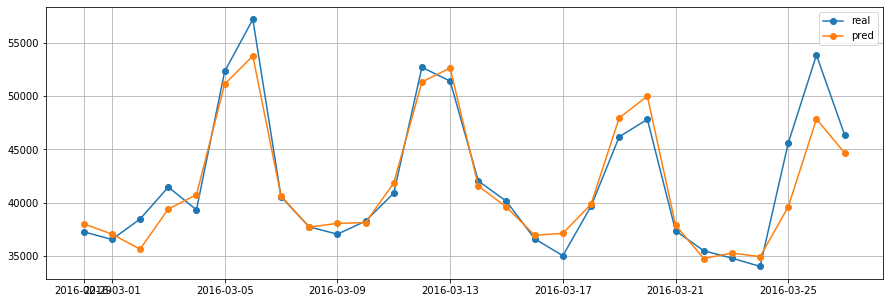

############################################## 13/13 ###############################################
##### Validation period: (Timestamp('2016-03-28 00:00:00'), Timestamp('2016-04-24 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1349.52it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's rmse: 2346.65
[50]	valid_0's rmse: 1665.38
[75]	valid_0's rmse: 1495.4
[100]	valid_0's rmse: 1426.16
[125]	valid_0's rmse: 1344.41
[150]	valid_0's rmse: 1314.9
[175]	valid_0's rmse: 1291.63
[200]	valid_0's rmse: 1281.85
[225]	valid_0's rmse: 1278.64
[250]	valid_0's rmse: 1299.08
[275]	valid_0's rmse: 1292.76
[300]	valid_0's rmse: 1323.19
[325]	valid_0's rmse: 1305.84
[350]	valid_0's rmse: 1285.2
[375]	valid_0's rmse: 1278.2
[400]	valid_0's rmse: 1270.04
[425]	valid_0's rmse: 1264.12
[450]	valid_0's rmse: 1270.66
[475]	valid_0's rmse: 1270.99
[500]	valid_0's rmse: 1276.26
[525]	valid_0's rmse: 1275.46
[550]	valid_0's rmse: 1276.96
[575]	valid_0's rmse: 1275.96
[600]	valid_0's rmse: 1277.57
[625]	valid_0's rmse: 1278.43
[650]	valid_0's rmse: 1280.58
Early stopping, best iteration is:
[419]	valid_0's rmse: 1260.2
RMSE: 1260.1965387751015
RMSSE: 0.2126550515519762


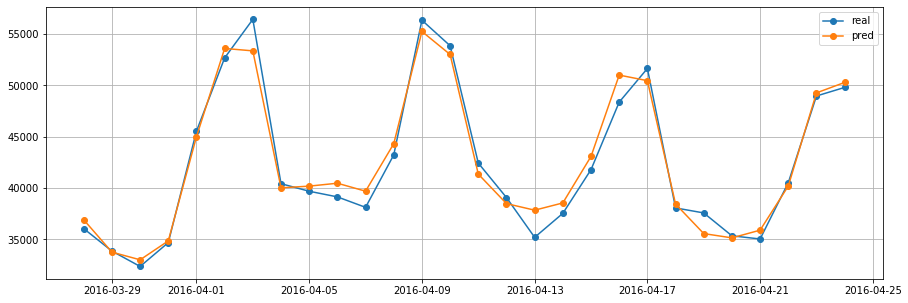

In [9]:
models = list()
errors = list()
best_iterations = list()

for i,valid_period in enumerate(valid_periods):
    print(f" {i+1}/{len(valid_periods)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)
        
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    model_kwargs["trend_models"] = compute_trend_models(_train_data,
                                                        _valid_index)

    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);

    _fcaster.train_features = reduce_mem_usage(_fcaster.train_features)
    _fcaster.valid_features = reduce_mem_usage(_fcaster.valid_features)
    
    _fcaster.fit(fit_kwargs={"verbose_eval":25})

    #lgb.plot_importance(_fcaster.model.model, importance_type="split", figsize=(10,8))
    #lgb.plot_importance(_fcaster.model.model, importance_type="gain", figsize=(10,8))
    
    models.append(_fcaster)
    errors.append(_fcaster.model.model.best_score["valid_0"]["rmse"])
    best_iterations.append(_fcaster.best_iteration)

    predictions = _fcaster.predict(_fcaster.valid_features.loc[:, data.columns.drop("y")])
    predictions = pd.merge(predictions,
                           _fcaster.valid_features.loc[:, ["ds","y_raw"]], 
                           how="inner", 
                           on=["ds"]).rename({"y_raw":"y"}, axis=1)
    
    error = np.sqrt(predictions.eval("(y_pred-y)**2").mean())

    print(f"RMSE: {error}")
    print(f"RMSSE: {error/scale_factor}")
    plt.figure(figsize=(15,5))
    plt.plot_date(predictions.ds, predictions.y, "o-", label="real")
    plt.plot_date(predictions.ds, predictions.y_pred, "o-", label="pred")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [10]:
np.mean(best_iterations)

510.6923076923077

In [11]:
np.mean(errors)/scale_factor

0.3325185092632322

***
### training final model

In [12]:
model_kwargs["model_params"]["num_iterations"] = int(np.median(best_iterations))
model_kwargs["model_params"]

{'objective': 'l2',
 'metric': 'rmse',
 'num_iterations': 341,
 'early_stopping_rounds': 250,
 'num_leaves': 23,
 'learning_rate': 0.1,
 'min_data_in_leaf': 20,
 'feature_fraction': 0.66,
 'bagging_fraction': 0.9,
 'bagging_freq': 1,
 'lambda_l2': 1.0,
 'seed': 23}

In [13]:
train_data = data.copy(deep=True)
all_models = list()

for seed in SEEDS:
    model_kwargs["model_params"]["seed"] = seed
    fcaster = LightGBMForecaster(**model_kwargs)
    fcaster.prepare_features(train_data=train_data);
    fcaster.fit()
    all_models.append(fcaster)

***
### estimating residuals

In [14]:
residual_variance = list()

for fcaster in all_models:
    predictions = fcaster.predict(train_data.loc[:, ["ds","event_name_1"]])
    rv = (pd.merge(train_data, predictions, how="inner", on="ds")
          .assign(residual = lambda x: x.y - x.y_pred)
          .residual.std())
    residual_variance.append(rv)

In [15]:
np.mean(residual_variance)

882.9388819910898

***
### prediction

In [53]:
valid_dataframe = (pd.read_parquet("../input/valid_dataframe.parquet")
                   .loc[:, ["ds","event_name_1"]]
                   .drop_duplicates())
eval_dataframe = (pd.read_parquet("../input/eval_dataframe.parquet")
                  .loc[:, ["ds","event_name_1"]]
                  .drop_duplicates())

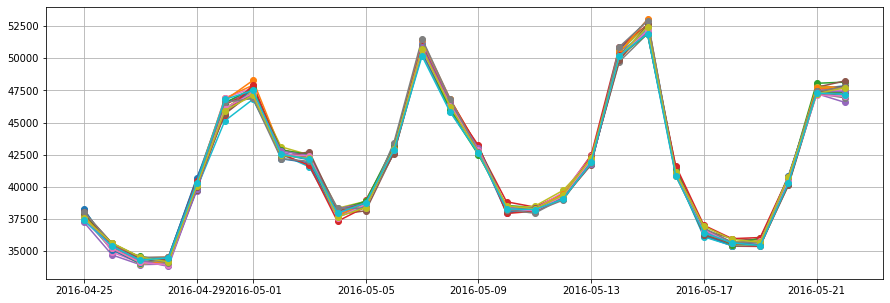

In [54]:
# visualizing the predictions over the validation period
plt.figure(figsize=(15,5))
for i,fcaster in enumerate(all_models):
    _forecast = fcaster.predict(valid_dataframe)    
    plt.plot_date(_forecast.ds, _forecast.y_pred, "o-", label=f"seed: {i}")
plt.grid()
plt.show()

In [38]:
all_forecasts = list()
for fcaster in all_models:
    _forecast = fcaster.predict(pd.concat([valid_dataframe, eval_dataframe], ignore_index=True))
    all_forecasts.append(_forecast)
    
forecast = all_forecasts[0].copy(deep=True)
forecast["y_pred"] = np.mean([_forecast.y_pred for _forecast in all_forecasts], axis=0)

In [39]:
forecast.to_csv("../output/forecast_level1.csv", index=False)

***